In [41]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

from wispy import lalutils, rotations 

In [42]:
!ls

__pycache__                 example-waveform-gen.ipynb
data_generation_coprec.py   model.png
data_generation_coprec.toml training_data_coprec_test
dev-data-gen-script.ipynb


In [43]:
!ls training_data_coprec_test/

alpha.npy  amp_22.npy coords.npy phi_21.npy times.npy
amp_21.npy beta.npy   gamma.npy  phi_22.npy


In [44]:
coords = np.load("training_data_coprec_test/coords.npy")

In [45]:
coords.shape

(7, 1)

In [46]:
coords.T[0]

array([1.44011032, 0.77954074, 1.04071558, 4.61842284, 0.2854129 ,
       1.93273242, 4.03695354])

In [47]:
coords[0]

array([1.44011032])

In [48]:
coords[1]

array([0.77954074])

In [49]:
times = np.load("training_data_coprec_test/times.npy")

In [50]:
betas = np.load("training_data_coprec_test/beta.npy")

In [51]:
amp_22s = np.load("training_data_coprec_test/amp_22.npy")

In [52]:
betas.shape

(1, 1199)

In [53]:
times.shape

(1199,)

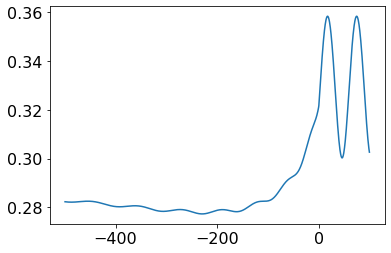

In [54]:
plt.figure()
for beta in betas:
    plt.plot(times, beta)

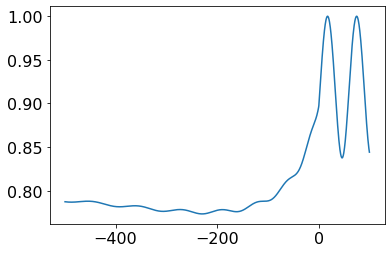

In [55]:
plt.figure()
for beta in betas:
    plt.plot(times, beta/np.max(betas))

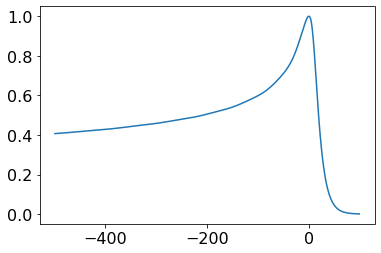

In [56]:
plt.figure()
for amp_22 in amp_22s:
    plt.plot(times, amp_22/np.max(amp_22s))
#     plt.plot(times, amp_22)
# plt.yscale('log')

# example how to read data in coprec frame and transform to inertial frame

In [57]:
def read_coprec_data(directory, index=0):
    times = np.load("training_data_coprec_test/times.npy")

    amp_22 = np.load("training_data_coprec_test/amp_22.npy")[index]
    amp_21 = np.load("training_data_coprec_test/amp_21.npy")[index]
    phi_22 = np.load("training_data_coprec_test/phi_22.npy")[index]
    phi_21 = np.load("training_data_coprec_test/phi_21.npy")[index]
    
    alpha = np.load("training_data_coprec_test/alpha.npy")[index]
    beta = np.load("training_data_coprec_test/beta.npy")[index]
    gamma = np.load("training_data_coprec_test/gamma.npy")[index]
    
    coords = np.load("training_data_coprec_test/coords.npy").T[index]

    hlms = {}
    hlms[(2,2)] = amp_22 * np.exp(1.j * phi_22)
    hlms[(2,1)] = amp_21 * np.exp(1.j * phi_21)
    hlms[(2,0)] = np.zeros(len(times))*1.j
    hlms[(2,-1)] = hlms[(2,1)].conj().copy()
    hlms[(2,-2)] = hlms[(2,2)].conj().copy()

    
    
    
    data = dict(
        coords=coords,
        times=times,
        amp_22=amp_22,
        amp_21=amp_21,
        phi_22=phi_22,
        phi_21=phi_21,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        hlms=hlms
    )
    
    return data

In [58]:
data = read_coprec_data("training_data_coprec_test/", index=0)

In [59]:
data['coords']

array([1.44011032, 0.77954074, 1.04071558, 4.61842284, 0.2854129 ,
       1.93273242, 4.03695354])

In [60]:
import data_generation_coprec

In [61]:
s1x, s1y, s1z = data_generation_coprec.polar_to_cart(data['coords'][1], data['coords'][2], data['coords'][3])
print(s1x, s1y, s1z)

-0.06310504284720907 -0.669594388630099 0.3941381432764964


In [62]:
s2x, s2y, s2z = data_generation_coprec.polar_to_cart(data['coords'][4], data['coords'][5], data['coords'][6])
print(s2x, s2y, s2z)

-0.16688948383871297 -0.20831510695058292 -0.10106058705024906


In [63]:
import phenom

In [64]:
from tomlkit import parse
with open("data_generation_coprec.toml", "r") as f:
    text = f.read()

doc = parse(text)

In [65]:
m1, m2 = phenom.m1_m2_M_q(doc['approx']['total_mass'], data['coords'][0])
print(m1, m2)

59.01824641283808 40.98175358716193


In [66]:
print(doc['approx']['f_ref'])
print(doc['approx']['phiRef'])

10.0
0


In [67]:
thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
    mass1=m1, mass2=m2, f_ref=doc['approx']['f_ref'], inc=0, phiref=doc['approx']['phiRef'],
    spin1x=s1x, spin1y=s1y, spin1z=s1z,
    spin2x=s2x, spin2y=s2y, spin2z=s2z,)
print(thetaJN, alpha0, phi_aligned)

0.22460983869520593 1.2246467991473532e-16 1.7551320001598065


In [68]:
wr = rotations.WaveformRotations(
    times=data['times'],
    hlms=data['hlms'], 
    frame='coprec',
    alpha=data['alpha'],
    beta=data['beta'],
    gamma=data['gamma']) 


In [69]:
wr.times

array([-499.51911337, -499.01911337, -498.51911337, ...,   98.48088663,
         98.98088663,   99.48088663])

In [70]:
wr.frame

'coprec'

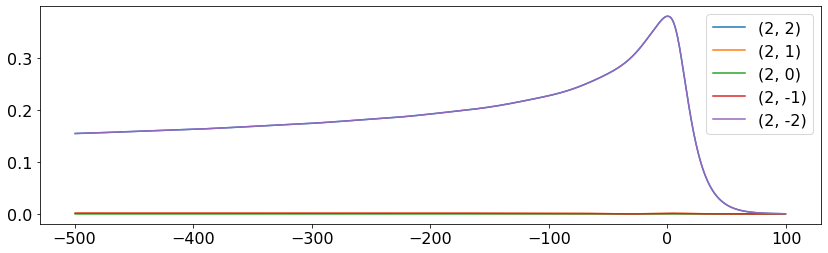

In [71]:
plt.figure(figsize=(14, 4))
for key in wr.hlms.keys():
    plt.plot(wr.times, np.abs(wr.hlms[key]), label=f"{key}")
plt.legend()

In [72]:
wr.set_alpha0_thetaJN_phi0(alpha0=alpha0, thetaJN=thetaJN, phi0=phi_aligned)

In [73]:
wr.from_coprecessing_frame_to_inertial_frame()

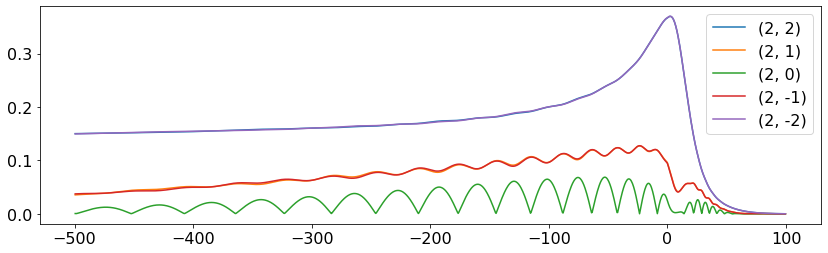

In [74]:
plt.figure(figsize=(14, 4))
for key in wr.hlms.keys():
    plt.plot(wr.times, np.abs(wr.hlms[key]), label=f"{key}")
plt.legend()

# generate a completely fresh waveform with the same parameters and compare the inertial frame modes - they should be the same

In [75]:
params = lalutils.gen_td_modes_wf_params(
    m1=m1,
    m2=m2,
    approximant=lalsim.SEOBNRv4P,
    S1x=s1x,
    S1y=s1y,
    S1z=s1z,
    S2x=s2x,
    S2y=s2y,
    S2z=s2z,
    f_min=10,
    phiRef=0,
    distance=1e6
)

test_times, test_hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=wr.times[0], t_max=wr.times[-1])

test_thetaJN, test_alpha0, test_phi_aligned = rotations.compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(test_thetaJN, test_alpha0, test_phi_aligned)

test_wr = rotations.WaveformRotations(
    times=test_times,
    hlms=test_hlms, 
    frame='inertial-L',
    alpha0=test_alpha0,
    thetaJN=test_thetaJN,
    phi0=test_phi_aligned) 

# test_wr.from_inertial_frame_to_coprecessing_frame()

0.22460983869520593 1.2246467991473532e-16 1.7551320001598065


In [76]:
mask = test_wr.times > wr.times[0]

In [77]:
test_wr.times[-1]

99.24733137574016

In [78]:
wr.times[-1]

99.48088662789587

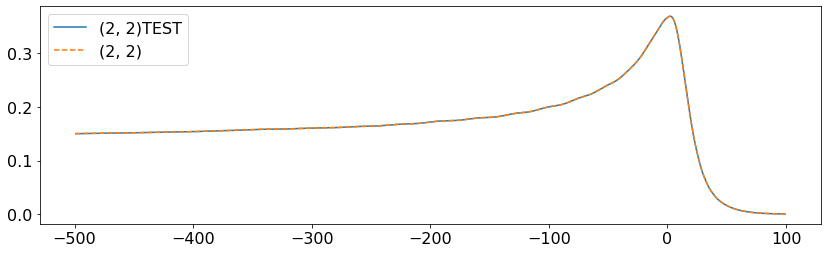

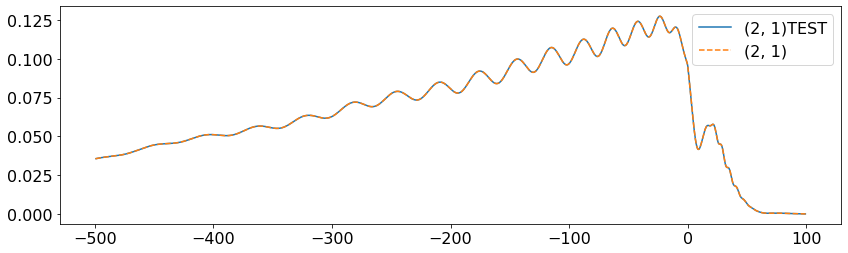

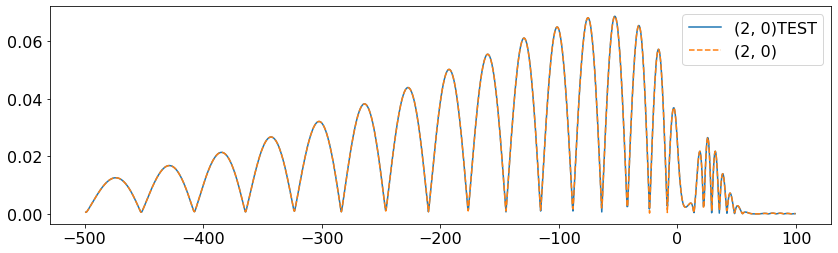

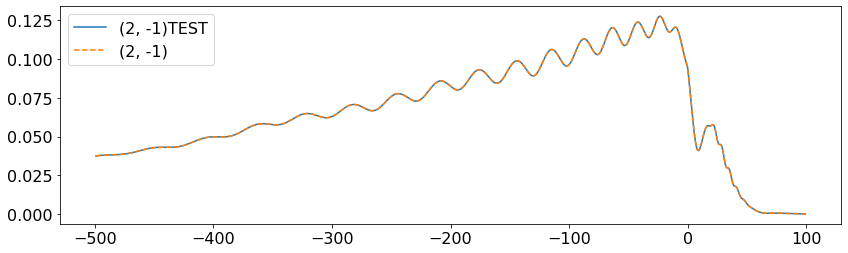

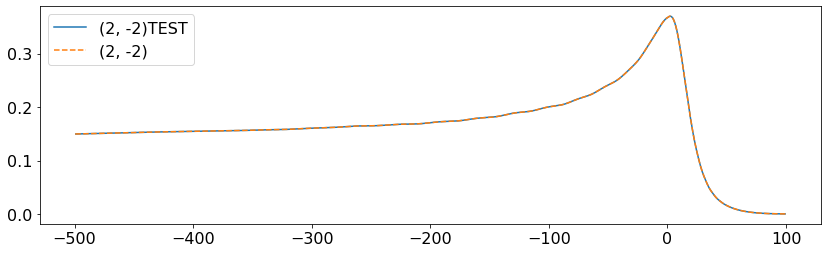

In [79]:
mask = test_wr.times > wr.times[0]
for key in test_wr.hlms.keys():
    plt.figure(figsize=(14, 4))
    plt.plot(test_wr.times[mask], np.abs(test_wr.hlms[key])[mask], label=f"{key}TEST")
    plt.plot(wr.times, np.abs(wr.hlms[key]), label=f"{key}", ls='--')
    plt.legend()
#     plt.xlim(-500, 200)
    plt.show()
    plt.close()

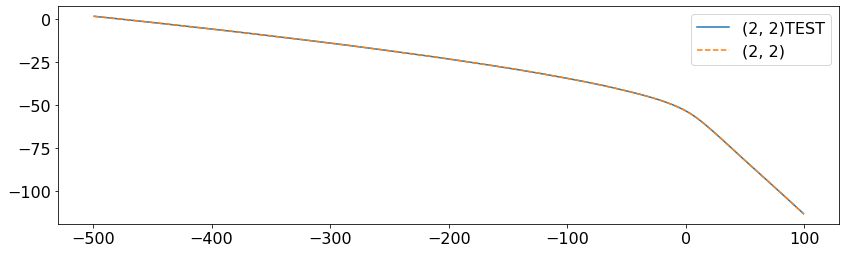

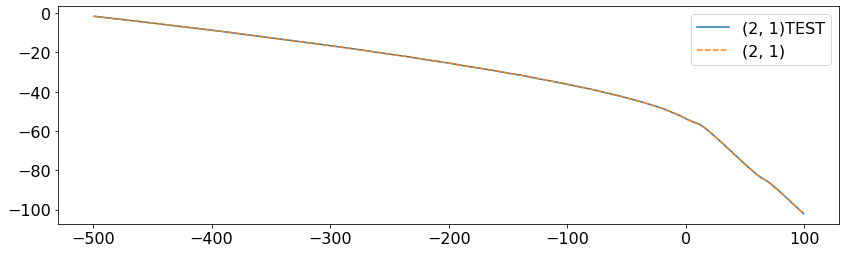

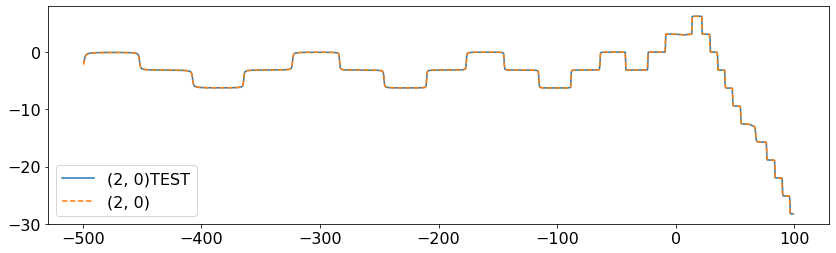

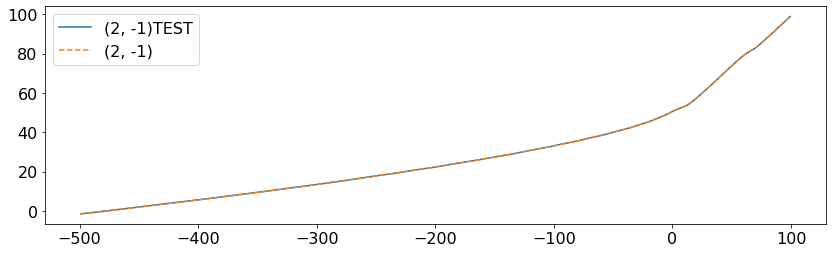

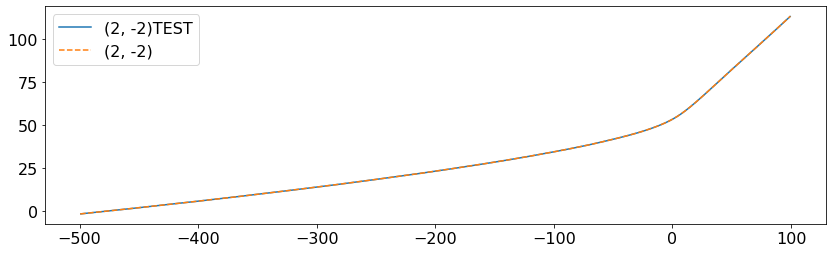

In [80]:
mask = test_wr.times > wr.times[0]
for key in test_wr.hlms.keys():
    plt.figure(figsize=(14, 4))
    plt.plot(test_wr.times[mask], np.unwrap(np.angle(test_wr.hlms[key]))[mask], label=f"{key}TEST")
    plt.plot(wr.times, np.unwrap(np.angle(wr.hlms[key])), label=f"{key}", ls='--')
    plt.legend()
#     plt.xlim(-500, 200)
    plt.show()
    plt.close()

# they are the same